##STEP 1 : Generate directed and undirected graphs from train.csv

In [ ]:
import networkx as nx
import requests
import csv
from io import StringIO

def get_directed_graph(file):
    G = nx.DiGraph()
    count = 1
    for row_data in file:
        if count % 1000 == 0:
            print(count)
        node = int(row_data[0])
        for neighbor in row_data[1:]:
            G.add_edge(node, int(neighbor))
        count +=1

    return G


def get_undirected_graph(file):
    G = nx.Graph()
    count = 1
    for row_data in file:
        if count % 1000 == 0:
            print(count)
        node = int(row_data[0])
        for neighbor in row_data[1:]:
            G.add_edge(node, int(neighbor))
        count +=1

    return G

#Read remote train.csv and parse it with csvreader:
url = 'https://media.githubusercontent.com/media/NeerajSura/PML/main/LinkPrediction/train.csv'
response = requests.get(url)
content = response.text
csv_reader = csv.reader(StringIO(content))


UG = get_undirected_graph(csv_reader)
#DG = get_directed_graph(csv_reader)
print("Number of nodes:", UG.number_of_nodes())
print("Number of edges:", UG.number_of_edges())



1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
Number of nodes: 4867136
Number of edges: 23415200


## Step 2 : Generate positive and negative samples from train.csv

In [ ]:
# create a train_dic dictionary which will be used for sampling
def make_train_data_dict(url):
  #Read remote train.csv and parse it with csvreader:
  response = requests.get(url)
  content = response.text
  csv_reader = csv.reader(StringIO(content))

  train_dict = {}
  for row in csv_reader:
    neighbor_list = [int(i) for i in row]
    train_dict[neighbor_list[0]] = set(neighbor_list[1:])
  return train_dict

# Get unique values of sources and sinks from train.csv
def get_train_sources_and_sinks_from_csv(url):
  #Read remote train.csv and parse it with csvreader:
  response = requests.get(url)
  content = response.text
  csv_reader = csv.reader(StringIO(content))

  sources = set()
  sinks = set()
  for row in csv_reader:
    sources.add(int(row[0]))
    for i in range(1, len(row)):
      sinks.add(int(row[i]))
  return sources, sinks


print("Making train dictionary from train.csv ...")
train_dict = make_train_data_dict(url)
print("Dictionary created successfully.")

train_sources, train_sinks = get_train_sources_and_sinks_from_csv(url)
print("Number of sources:", len(train_sources))
print("Number of sinks:", len(train_sinks))


Making train dictionary from train.csv ...
Dictionary created successfully.
Number of sources: 20000
Number of sinks: 4867136


In [ ]:
#Generate positive and negative pairs
import random
import numpy as np

def positive_sampling(n_samples):
    print(f"Sampling {n_samples} Positive pairs")
    positive_samples=[]
    count=0
    for i in range(n_samples):
        if (count % 1000 == 0):
            print(count)
        count+=1
        source_random_index=random.randint(0,19999)
        source=(list(train_sources))[source_random_index]
        chosen_source_sinks=train_dict[source] # fetch neighbors of selected source from train_dict
        try:
            sink=random.choice(list(chosen_source_sinks)) # chose any random neighbor
            positive_samples.append((source,sink)) # append to the list
        except:
            pass
    print('Length of positive samples list is :', len(positive_samples))
    return positive_samples


def negative_sampling(n_samples):
    print(f"Sampling {n_samples} Negative pairs")
    negative_samples=[]
    count = 0
    for i in range(n_samples):
        if (count % 1000 == 0):
            print(count)
        count+=1
        source_random_index=random.randint(0,19999)
        source=(list(train_sources))[source_random_index]
        chosen_source_sinks=train_dict[source] # fetch neighbors of selected source from train_dict
        sink=random.choice(list(train_sinks)) # Choose any random neighbor node from any source
        if sink not in chosen_source_sinks: # If chosen neighbor is not in the neighbors of chosen source then we have a negative pair
            negative_samples.append((source, sink))
    print('Length of negative samples list is :', len(negative_samples))
    return negative_samples

num_samples = 20000
positive_samples=positive_sampling(num_samples)
np.save('positive_samples.npy',np.array(positive_samples)) # Save as np array for future reference

negative_samples=negative_sampling(num_samples)
np.save('negative_samples.npy',np.array(negative_samples)) # Save as np array for future reference


Sampling 20000 Positive pairs
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
Length of positive samples list is : 19552
Sampling 20000 Negative pairs
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
Length of negative samples list is : 19994


In [ ]:
from google.colab import files
files.upload()

Saving test.csv to test.csv


{'test.csv': b'\xef\xbb\xbfId,From,To\r1,3360982,4457271\r2,4761876,4698439\r3,4198430,3615486\r4,2945770,747948\r5,3950088,3360335\r6,2483976,1928881\r7,2785328,2672575\r8,385505,2877637\r9,4800097,1627742\r10,1399778,3338838\r11,178544,933485\r12,3116667,3394409\r13,4822324,3798666\r14,1014631,34363\r15,3637130,4624715\r16,572186,3573892\r17,4367817,848637\r18,2740302,4432643\r19,697676,774739\r20,233754,4372301\r21,2356466,2928383\r22,4511229,1707831\r23,1334864,4734827\r24,4823249,1941668\r25,2495939,3611146\r26,4539933,3701998\r27,2267515,299146\r28,414044,485185\r29,1770141,3706320\r30,4825426,2222470\r31,3571629,1964039\r32,2607822,4362893\r33,1606185,3693868\r34,2245172,4670041\r35,1668501,618303\r36,4801585,1889842\r37,4461666,3254522\r38,622210,4323012\r39,2988815,1276204\r40,3364505,3274350\r41,2842255,2202632\r42,121165,442888\r43,1902150,1982099\r44,2504780,4425830\r45,3515936,2226043\r46,1341663,194531\r47,2374063,1540939\r48,2695970,324371\r49,1274819,817807\r50,4468501,

In [ ]:
import pandas as pd
import numpy as np

positive_samples=np.load("20K_positive_samples.npy").tolist()
negative_samples=np.load("20K_negative_samples.npy").tolist()

def get_test_samples():
    test_data = pd.read_csv('test.csv')
    columns_to_convert = ['From', 'To']
    test_samples = test_data[columns_to_convert].values
    return test_samples.tolist()
test_samples = get_test_samples()

## STEP 3 : Feature Engineering

####1.Undirected Graph Features

In [ ]:
import networkx as nx
import csv
import numpy as np

def extract_features_positive_samples():
    features = []
    count = 0
    print("Generating positive samples features......")
    for sample in positive_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            preds = nx.resource_allocation_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.jaccard_coefficient(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.adamic_adar_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.preferential_attachment(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            feature.append(1)  # label=1

        except Exception as e:
            print("one error at: "+str(count))
            print(e)
            pass
        features.append(feature)
    print("positive samples features: "+str(len(features)))
    return features


def extract_features_negative_samples():
    features = []
    count = 0
    print("Generating negative samples features......")
    for sample in negative_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            preds = nx.resource_allocation_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.jaccard_coefficient(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.adamic_adar_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.preferential_attachment(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            feature.append(0)  # label=0
        except Exception as e:
            print("one error at: "+str(count))
            print(e)
            pass
        features.append(feature)

    print("negative samples features: "+str(len(features)))
    return features

def extract_features_test_samples():
    features = []
    count = 0
    print("Generating test samples features......")
    for sample in test_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            preds = nx.resource_allocation_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.jaccard_coefficient(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.adamic_adar_index(UG, [sample])
            for u, v, p in preds:
                feature.append(p)

            preds = nx.preferential_attachment(UG, [sample])
            for u, v, p in preds:
                feature.append(p)
        except Exception as e:
            print("one error at: "+str(len(count)))
            print(e)
            pass
        features.append(feature)

    return features

# add features and label, combine
def generate_traning_data_from_UG():
    positive_features_ug = extract_features_positive_samples()
    negative_features_ug = extract_features_negative_samples()
    features_ug = positive_features_ug + negative_features_ug
    # random.shuffle(features)
    return features_ug


traning_data_ug = generate_traning_data_from_UG()

def write_train_to_csv(traning_data):
    with open("train_ug_20k_samples.csv","w",newline="") as csvfile:
        writer=csv.writer(csvfile)
        writer.writerow(["RA","JC","AA","PA","Label"])
        writer.writerows(traning_data)

write_train_to_csv(traning_data_ug)

def write_test_to_csv(test_data):
    with open("test_ug_20k_samples.csv","w",newline="") as csvfile:
        writer=csv.writer(csvfile)
        writer.writerow(["RA","JC","AA","PA"])
        writer.writerows(test_data)

test_data=extract_features_test_samples()
write_test_to_csv(test_data)



Generating positive samples features......
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
positive samples features: 19588
Generating negative samples features......
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
negative samples features: 19995
Generating test samples features......
0
1000


####2.Sparse Adjacency Matrix Features

In [ ]:
# Construct Adjacency Matrix
import requests
from scipy.sparse import csr_matrix

print("Generating matrix......")

# Fetching CSV data from GitHub
url = 'https://github.com/NeerajSura/PML/raw/main/LinkPrediction/train.csv'
response = requests.get(url)

row = []
col = []
data = []

# Parsing CSV data
for line in response.text.split('\n'):
    if line.strip():  # Check if the line is not empty
        neighbour_list = [int(i) for i in line.split(',') if i.strip()]  # Remove empty values
        for i in range(1, len(neighbour_list)):
            row.append(neighbour_list[0])
            col.append(neighbour_list[i])
            data.append(1)

# Constructing CSR matrices
source_sink_matrix = csr_matrix((data, (row, col)), shape=(4867136, 4867136))
sink_source_matrix = csr_matrix((data, (col, row)), shape=(4867136, 4867136))

Generating matrix......


In [ ]:
from math import sqrt

def cos_sim(X,Y):
    try:
        return (np.dot(X,Y.T)/(sqrt(X.nnz)*sqrt(Y.nnz))).toarray()[0][0]
    except:
        return 0

def pre_pre_cos(key1,key2):
    return cos_sim(sink_source_matrix[key1],sink_source_matrix[key2])
def suc_pre_cos(key1,key2):
    return cos_sim(source_sink_matrix[key1],sink_source_matrix[key2])


In [ ]:
def extract_features_positive_samples():
    features = []
    count = 0
    print("Generating positive samples features......")
    for sample in positive_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            feature.append(pre_pre_cos(sample[0], sample[1]))
            feature.append(suc_pre_cos(sample[0], sample[1]))
            feature.append(1)  # label=1

        except Exception as e:
            print(e)
            pass
        features.append(feature)
    print("positive samples features: " + str(len(features)))
    return features

def extract_features_negative_samples():
    features = []
    count = 0
    print("Generating negative samples features......")
    for sample in negative_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            feature.append(pre_pre_cos(sample[0], sample[1]))
            feature.append(suc_pre_cos(sample[0], sample[1]))
            feature.append(0)  # label=0
        except:
            print("one error at: " + str(count))
            pass
        features.append(feature)
    print("negative samples features: " + str(len(features)))
    return features

def extract_features_test_samples():
    features = []
    count = 0
    print("Generating test samples features......")
    for sample in test_samples:
        if (count % 1000 == 0):
            print(count)
        count += 1
        feature = []
        try:
            feature.append(pre_pre_cos(sample[0], sample[1]))
            feature.append(suc_pre_cos(sample[0], sample[1]))
        except:
            print("one error at: " + str(count))
            pass
        features.append(feature)
    print("test samples features: " + str(len(features)))
    return features


def generate_traning_data_from_CSR():
    positive_features_csr = extract_features_positive_samples()
    negative_features_csr = extract_features_negative_samples()
    features_csr = positive_features_csr + negative_features_csr
    # random.shuffle(features)
    return features_csr

traning_data = generate_traning_data_from_CSR()

def write_train_to_csv(traning_data):
    with open("train_csr_10k_samples.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["PPS", "SPS","Label"])
        writer.writerows(traning_data)
write_train_to_csv(traning_data)

def write_test_to_csv(test_data):
    with open("test_csr_10k_samples.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["PPS", "SPS"])
        writer.writerows(test_data)
test_data = extract_features_test_samples()
write_test_to_csv(test_data)


Generating positive samples features......
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
positive samples features: 9783
Generating negative samples features......
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
negative samples features: 9995
Generating test samples features......
0
1000
test samples features: 2000


## STEP 4 : Modelling


####LightGBM Boosting

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import pandas as pd
# Importing the dataset
dataset = pd.read_csv('train_merged_20k_samples.csv')
dataset

,RA,JC,AA,PA,PPS,SPS,Label
0,0.000000,0.000000,0.000000,665,0.000000,0.000000,1
1,0.000000,0.000000,0.000000,6,0.000000,0.000000,1
2,0.083930,0.110465,3.288578,7638,0.364405,0.242831,1
3,0.000000,0.000000,0.000000,66,0.000000,0.000000,1
4,0.022514,0.024390,0.866209,2000,0.271163,0.113813,1
...,...,...,...,...,...,...,...
39578,0.000000,0.000000,0.000000,330,0.000000,0.000000,0
39579,0.000000,0.000000,0.000000,126,0.000000,0.000000,0
39580,0.000000,0.000000,0.000000,368,0.000000,0.000000,0
39581,0.000000,0.000000,0.000000,23,0.000000,0.000000,0


In [ ]:
FEATURE_SIZE=6
feature_names = dataset.columns[:FEATURE_SIZE]
print(feature_names)

X = dataset.iloc[:,:FEATURE_SIZE].values
y = dataset.iloc[:, FEATURE_SIZE].values


Index(['RA', 'JC', 'AA', 'PA', 'PPS', 'SPS'], dtype='object')


In [ ]:
X.shape

(39583, 6)

In [ ]:
y.shape

(39583,)

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = 0.2, random_state = 42)

In [ ]:
x_train.shape

(31666, 6)

In [ ]:
x_val.shape

(6333, 6)

In [ ]:
x_test.shape

(1584, 6)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val=sc.transform(x_val)

In [ ]:
import lightgbm as lgb

# Training
d_train = lgb.Dataset(x_train, label=y_train)
d_val = lgb.Dataset(x_val, label=y_val)
d_test=lgb.Dataset(x_test,label=y_test)

params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
#             'boosting_type': 'rf',
            'nthread': 4,
            'learning_rate': 0.02,  # 02,
            'num_leaves': 15,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.7,
            'bagging_freq': 1,
            'early_stopping_round':5,
            'max_depth':2,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 60,
            'seed': 0,
            'verbose': 1,
            'metric': 'auc',
}


clf = lgb.train(params, d_train, 30,d_val)

[LightGBM] [Info] Number of positive: 15680, number of negative: 15986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 31666, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495168 -> initscore=-0.019327
[LightGBM] [Info] Start training from score -0.019327
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.873522


In [ ]:
#Prediction
y_pred=clf.predict(x_test)
#convert into binary values
for i in range(len(y_pred)):
    if y_pred[i]>=0.5:       # setting threshold to .5
       y_pred[i]=1
    else:
       y_pred[i]=0

#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)
print(accuracy)

# AUC
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.8421717171717171
0.8423356710024343


In [ ]:
testdata = pd.read_csv('test_merged_20k_samples.csv')
x_testing = testdata.iloc[:,0:FEATURE_SIZE].values
x_testing = sc.transform(x_testing)
predictions=clf.predict(x_testing)

In [ ]:
x_testing.shape

(2000, 6)

In [ ]:
predictions.shape

(2000,)

In [ ]:
import csv
with open("Predictions_exp6.csv","w",newline="") as csvfile:
    writer=csv.writer(csvfile)
    writer.writerow(["Id","Predictions"])
    test_id=1
    for prediction in predictions:
        writer.writerow([test_id,prediction])
        test_id+=1

In [ ]:
import lightgbm as lgb

# Training
d_train = lgb.Dataset(x_train, label=y_train)
d_val = lgb.Dataset(x_val, label=y_val)
d_test=lgb.Dataset(x_test,label=y_test)


params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'nthread': 4,
    'learning_rate': 0.01,  # Lower learning rate
    'num_leaves': 31,  # Increased number of leaves
    'feature_fraction': 0.8,  # Reduced feature fraction
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'early_stopping_round': 10,  # Increased early stopping rounds
    'max_depth': 3,
    'reg_alpha': 0.1,  # Increased regularization
    'reg_lambda': 0.1,
    'min_split_gain': 0.01,
    'min_child_weight': 50,
    'seed': 0,
    'metric': 'auc',
    'verbose': 1,
}

clf = lgb.train(params, d_train, num_boost_round=1000, valid_sets=[d_train, d_val])


[LightGBM] [Info] Number of positive: 15680, number of negative: 15986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 31666, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495168 -> initscore=-0.019327
[LightGBM] [Info] Start training from score -0.019327
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's auc: 0.884871	valid_1's auc: 0.879357


In [ ]:
#Prediction
y_pred=clf.predict(x_test)
#convert into binary values
for i in range(len(y_pred)):
    if y_pred[i]>=0.5:       # setting threshold to .5
       y_pred[i]=1
    else:
       y_pred[i]=0

#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)
print(accuracy)

# AUC
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.8421717171717171
0.8423356710024343


In [ ]:
testdata = pd.read_csv('test_merged_20k_samples.csv')
x_testing = testdata.iloc[:,0:FEATURE_SIZE].values
x_testing = sc.transform(x_testing)
predictions=clf.predict(x_testing)

In [ ]:
import csv
with open("Predictions_exp6.csv","w",newline="") as csvfile:
    writer=csv.writer(csvfile)
    writer.writerow(["Id","Predictions"])
    test_id=1
    for prediction in predictions:
        writer.writerow([test_id,prediction])
        test_id+=1

In [ ]:
clf.params

{'objective': 'binary',
 'boosting_type': 'gbdt',
 'nthread': 4,
 'learning_rate': 0.01,
 'num_leaves': 31,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'early_stopping_round': 10,
 'max_depth': 3,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'min_split_gain': 0.01,
 'min_child_weight': 50,
 'seed': 0,
 'metric': 'auc',
 'verbose': 1,
 'num_iterations': 1000}

**SUMMARY**

##Comparison of all 3 Classifiers Used [Best Predictions comparison]

**1. RandomForestClassifier**  
***Parameters*** : max_depth=10, min_samples_split=10, n_estimators=200, random_state=42  
***Num_samples*** - 20K  
***Features*** - RA	JC	AA	PA	PPS	SPS  
***AUC_score*** - 0.888   

**2. Logistic Regression:**  
***Parameters*** : max_iter=1000, C=1e4,penalty='l2'   
***Num_samples*** - 20K  
***Features*** - RA	JC	AA	PA	PPS	SPS  
***AUC_score*** - 0.892

**3. LightGBM Classifier:**  
***Parameters*** : {'objective': 'binary',
 'boosting_type': 'gbdt',
 'nthread': 4,
 'learning_rate': 0.01,
 'num_leaves': 31,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'early_stopping_round': 10,
 'max_depth': 3,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'min_split_gain': 0.01,
 'min_child_weight': 50,
 'seed': 0,
 'metric': 'auc',
 'verbose': 1,
 'num_iterations': 1000}  
 ***Num_samples*** - 20K  
***Features*** - RA	JC	AA	PA	PPS	SPS  
***AUC_score*** - 0.9


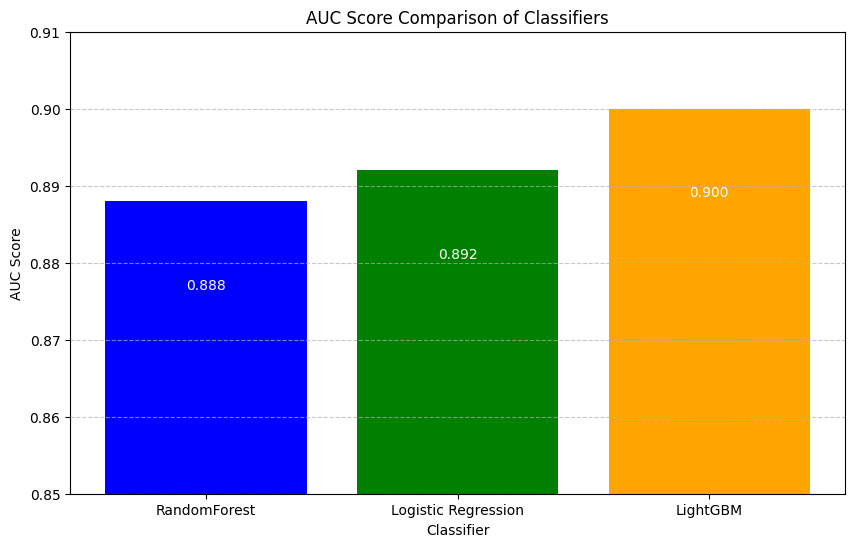

In [6]:
import matplotlib.pyplot as plt

# Classifier names
classifiers = ['RandomForest', 'Logistic Regression', 'LightGBM']

# AUC scores
auc_scores = [0.888, 0.892, 0.9]

# Plotting the comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, auc_scores, color=['blue', 'green', 'orange'])
plt.title('AUC Score Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('AUC Score')
plt.ylim(0.85, 0.91)  # Adjust ylim to better visualize the differences
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add AUC values inside the bars
for bar, auc_score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.01, f'{auc_score:.3f}',
             ha='center', va='top', color='white')

plt.show()

